In [1]:
!python --version

Python 3.9.13


In [4]:
!pip3 install kaggle

  Using cached kaggle-1.5.12-py3-none-any.whl
     |████████████████████████████████| 140 kB 4.8 MB/s eta 0:00:01
     |████████████████████████████████| 160 kB 18.1 MB/s eta 0:00:01
  Using cached python_slugify-6.1.2-py2.py3-none-any.whl (9.4 kB)
     |████████████████████████████████| 62 kB 3.7 MB/s  eta 0:00:01
  Using cached tqdm-4.64.1-py2.py3-none-any.whl (78 kB)
  Using cached text_unidecode-1.3-py2.py3-none-any.whl (78 kB)
     |████████████████████████████████| 61 kB 14.2 MB/s eta 0:00:01


In [10]:
%cd Data

/home/studio-lab-user/sagemaker-studiolab-notebooks/Capstone/Data


In [11]:
!pwd

/home/studio-lab-user/sagemaker-studiolab-notebooks/Capstone/Data


In [6]:
mkdir /home/studio-lab-user/.kaggle

In [8]:
!cp kaggle.json /home/studio-lab-user/.kaggle

In [12]:
!kaggle competitions download -c m5-forecasting-accuracy

 90%|██████████████████████████████████    | 41.0M/45.8M [00:01<00:00, 44.9MB/s]
100%|██████████████████████████████████████| 45.8M/45.8M [00:01<00:00, 39.9MB/s]


In [13]:
!unzip m5-forecasting-accuracy.zip

Archive:  m5-forecasting-accuracy.zip
  inflating: calendar.csv            
  inflating: sales_train_evaluation.csv  
  inflating: sales_train_validation.csv  
  inflating: sample_submission.csv   
  inflating: sell_prices.csv         


In [195]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from statsmodels.tsa.arima_process import ArmaProcess
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer

In [14]:
train = pd.read_csv('Data/sales_train_validation.csv')
cal = pd.read_csv('Data/calendar.csv')
prices = pd.read_csv('Data/sell_prices.csv')

In [15]:
time_series = train.set_index("id")

In [16]:
time_series_sales = time_series.iloc[:,5:]

In [7]:
reduced_cal = cal[cal.weekday=='Sunday']

In [9]:
price_date = prices.merge(reduced_cal,left_on="wm_yr_wk",right_on="wm_yr_wk")

In [10]:
price_date['id'] = price_date['item_id'] + '_' + price_date['store_id'] + '_validation'

In [11]:
price_date = price_date.loc[:,['id', 'sell_price','date']]

In [13]:
time_series_prices = price_date.groupby(['id','date']).mean().unstack()

In [17]:
time_series_sales.to_csv('time_series_sales.csv',index=True)

In [23]:
time_series_sales = pd.read_csv('time_series_sales.csv',index_col=0)

In [24]:
time_series_sales

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
id,,,,,,,,,,,,,,,,,,,,,
HOBBIES_1_001_CA_1_validation,0,0,0,0,0,0,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
HOBBIES_1_002_CA_1_validation,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
HOBBIES_1_003_CA_1_validation,0,0,0,0,0,0,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
HOBBIES_1_004_CA_1_validation,0,0,0,0,0,0,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
HOBBIES_1_005_CA_1_validation,0,0,0,0,0,0,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FOODS_3_823_WI_3_validation,0,0,2,2,0,3,1,4,1,0,...,2,0,0,0,0,0,1,0,0,1
FOODS_3_824_WI_3_validation,0,0,0,0,0,5,0,1,1,3,...,0,0,0,0,0,0,0,0,1,0
FOODS_3_825_WI_3_validation,0,6,0,2,2,4,1,8,5,2,...,2,1,0,2,0,1,0,0,1,0


In [47]:
def acf(x, n_lags):
    return sm.tsa.stattools.acf(x, nlags=n_lags)

n_lags = 365

In [48]:
lag_array = np.repeat(n_lags, time_series_sales.shape[0])

In [49]:
acf_list = list(map(acf, time_series_sales.to_numpy(), lag_array))

In [50]:
acf_df = pd.DataFrame(acf_list).transpose()

In [51]:
acf_df.columns = time_series_sales.index

In [52]:
acf_df

id,HOBBIES_1_001_CA_1_validation,HOBBIES_1_002_CA_1_validation,HOBBIES_1_003_CA_1_validation,HOBBIES_1_004_CA_1_validation,HOBBIES_1_005_CA_1_validation,HOBBIES_1_006_CA_1_validation,HOBBIES_1_007_CA_1_validation,HOBBIES_1_008_CA_1_validation,HOBBIES_1_009_CA_1_validation,HOBBIES_1_010_CA_1_validation,...,FOODS_3_818_WI_3_validation,FOODS_3_819_WI_3_validation,FOODS_3_820_WI_3_validation,FOODS_3_821_WI_3_validation,FOODS_3_822_WI_3_validation,FOODS_3_823_WI_3_validation,FOODS_3_824_WI_3_validation,FOODS_3_825_WI_3_validation,FOODS_3_826_WI_3_validation,FOODS_3_827_WI_3_validation
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.230593,0.125627,0.288903,0.108732,0.238397,0.155965,0.074475,0.154996,0.034998,0.087535,...,0.373863,0.517720,0.107825,0.254451,0.523709,0.515567,0.219352,0.396220,0.398870,0.391214
2,0.211897,0.136811,0.295814,-0.007495,0.137893,0.087232,0.074830,0.100922,0.023868,0.044120,...,0.340776,0.486973,0.062580,0.246054,0.449726,0.475082,0.189185,0.356018,0.364507,0.336896
3,0.178373,0.106056,0.327026,-0.012488,0.092323,0.065850,0.091189,0.100390,0.042145,0.024197,...,0.321541,0.486470,0.052410,0.242069,0.420563,0.468585,0.206973,0.356345,0.307939,0.340001
4,0.148125,0.104336,0.282791,0.024334,0.088265,0.125593,0.045822,0.111694,0.041907,-0.000748,...,0.297296,0.473539,0.034156,0.257978,0.402800,0.430214,0.184295,0.362881,0.318607,0.324961
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,0.098875,0.080552,0.026107,-0.046976,0.002900,-0.054236,0.006873,0.027440,0.031391,-0.033965,...,0.047245,0.011249,-0.013187,0.063307,0.048798,-0.017251,0.032618,-0.021727,-0.003546,0.098604
362,0.095424,0.043761,0.043730,-0.017816,-0.001158,-0.062254,0.054095,0.016099,0.055168,-0.004634,...,0.028062,0.016126,0.043124,0.071596,0.053854,-0.014340,0.050407,-0.028542,-0.018325,0.109748
363,0.123160,0.105365,0.014960,0.056445,0.008528,-0.062500,0.004614,0.048872,0.021497,-0.014361,...,0.031932,0.034711,0.035458,0.116832,0.058211,-0.011429,0.064304,-0.016828,-0.008222,0.078349
364,0.132310,0.108899,0.025956,0.142234,0.079380,-0.047234,0.027145,-0.002059,0.027700,0.065627,...,0.086065,0.016450,0.064119,0.098880,0.076496,-0.010782,0.047852,-0.001271,-0.015650,0.122887


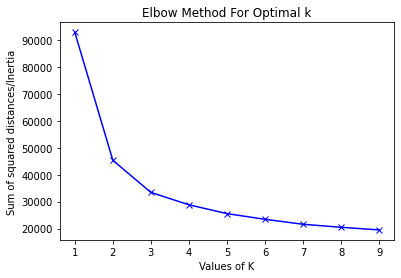

In [53]:
Sum_of_squared_distances = []
K = range(1,10)
for num_clusters in K :
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(acf_df.transpose())
    Sum_of_squared_distances.append(kmeans.inertia_)
plt.plot(K,Sum_of_squared_distances,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Sum of squared distances/Inertia') 
plt.title('Elbow Method For Optimal k')
plt.show()

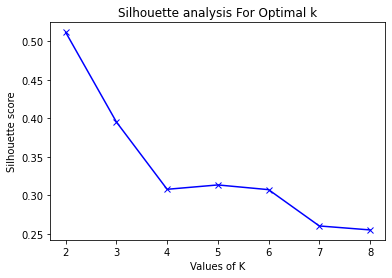

In [61]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
silhouette_avg = []
for num_clusters in range_n_clusters:
 
 # initialise kmeans
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(acf_df.transpose())
    cluster_labels = kmeans.labels_
 
 # silhouette score
    silhouette_avg.append(silhouette_score(acf_df.transpose(), cluster_labels))
plt.plot(range_n_clusters,silhouette_avg,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Silhouette score') 
plt.title('Silhouette analysis For Optimal k')
plt.show()

In [62]:
n_clusters = 6
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(acf_df.transpose())
kmeans.labels_

array([3, 0, 5, ..., 4, 2, 3], dtype=int32)

In [66]:
clustered_df = acf_df.transpose()

In [67]:
clustered_df['cluster'] = kmeans.labels_

In [101]:
sample_df = clustered_df[clustered_df['cluster']==0].sample(10)
for i in range(1,n_clusters):
    sample_df = pd.concat([sample_df, clustered_df[clustered_df['cluster']==i].sample(10)], ignore_index=False)

In [104]:
len(sample_df)

60

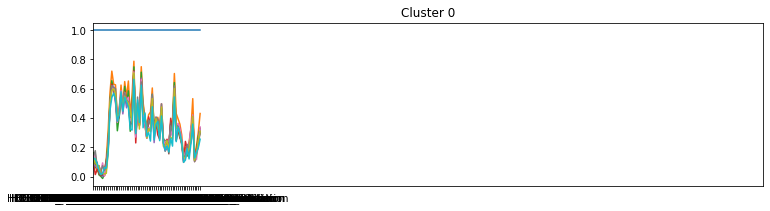

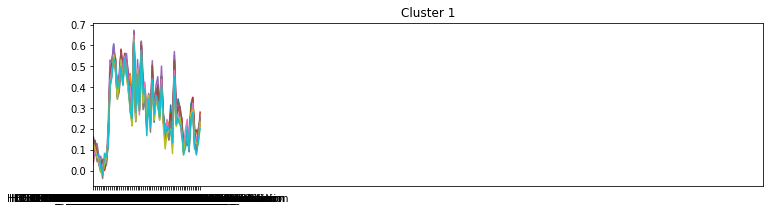

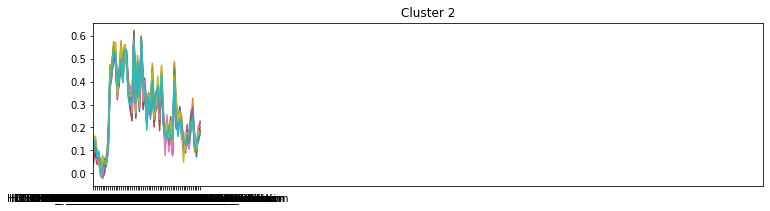

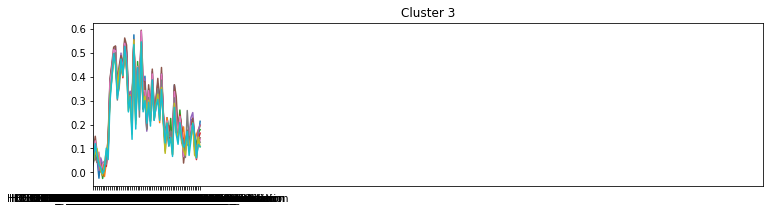

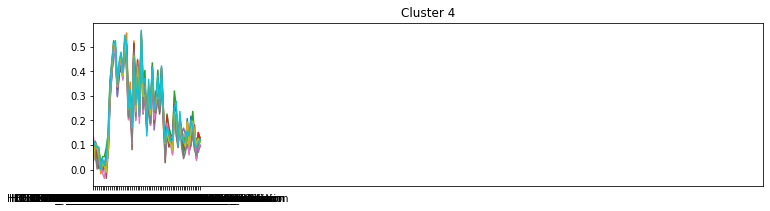

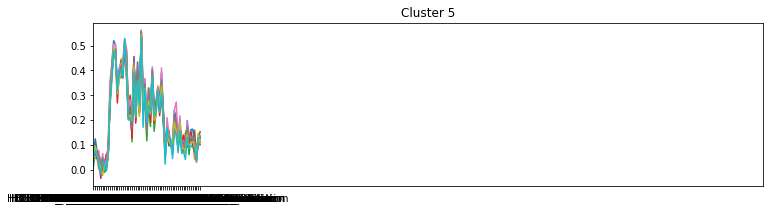

In [98]:

# i ranges over clusters
for i in range(n_clusters):
    plt.figure(figsize=(12, 3))
    plt.xlim((1, n_lags))
    ts = []

    # j ranges over the series ACFs
    for j in range(len(sample_df)):
        # Plot ACF j in the current cluster i
        if sample_df['cluster'][j] == i:
            ts.append(j)
            plt.plot(sample_df.transpose().iloc[:, j])
    
    plt.title(f"Cluster {i}\nTime series {ts}")
    plt.show()

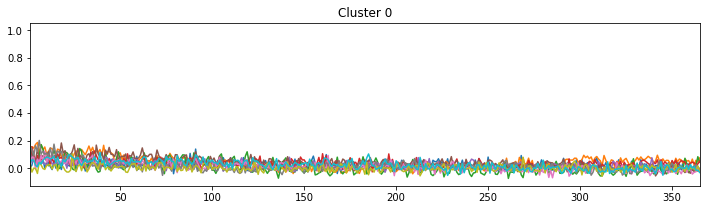

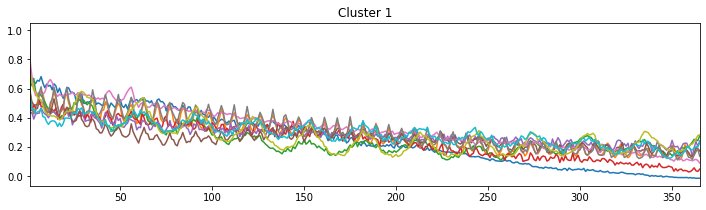

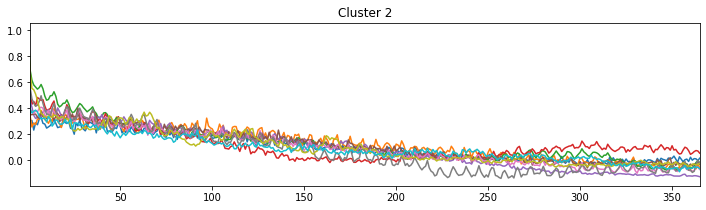

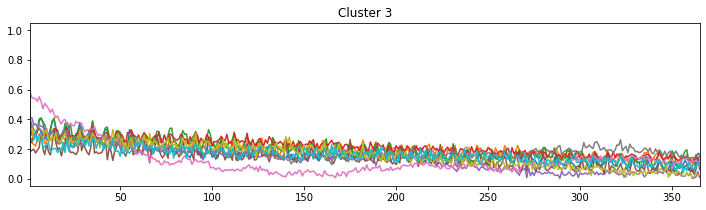

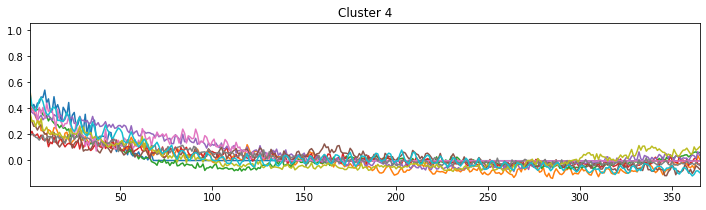

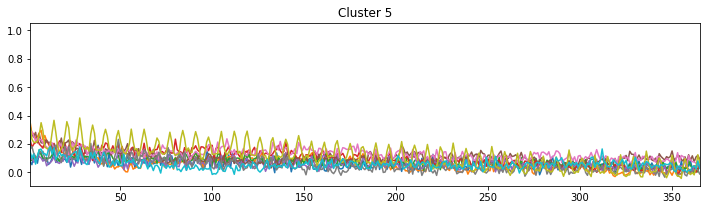

In [109]:
for i in range(n_clusters):
    plt.figure(figsize=(12, 3))
    plt.xlim((1, n_lags))
    to_plot = sample_df[sample_df.cluster==i]
    for j in range(len(to_plot)):
        plt.plot(to_plot.transpose().iloc[:366,j])
    plt.title(f"Cluster {i}")
    plt.show()

,0,1,2,3,4,5,6,7,8,9,...,357,358,359,360,361,362,363,364,365,cluster
id,,,,,,,,,,,,,,,,,,,,,
FOODS_3_747_WI_1_validation,1.0,0.398421,0.389919,0.376320,0.356878,0.388440,0.349767,0.384345,0.430288,0.362833,...,0.119001,0.139431,0.131217,0.160477,0.143090,0.117046,0.138048,0.151485,0.165327,1
FOODS_3_440_CA_3_validation,1.0,0.414121,0.362299,0.320201,0.354469,0.357313,0.315381,0.345477,0.322945,0.378857,...,0.144532,0.149188,0.138075,0.176627,0.124640,0.151984,0.139117,0.145584,0.134032,1
FOODS_3_288_CA_3_validation,1.0,0.823968,0.736310,0.695993,0.681015,0.682117,0.707987,0.716370,0.677162,0.642791,...,0.245004,0.246228,0.225829,0.230003,0.227472,0.228042,0.240937,0.254890,0.236640,1
FOODS_3_329_WI_1_validation,1.0,0.760757,0.681366,0.684915,0.659866,0.644262,0.677915,0.687169,0.642572,0.576681,...,0.051584,0.058188,0.041329,0.040956,0.049416,0.049765,0.052881,0.085326,0.077021,1
FOODS_3_780_CA_3_validation,1.0,0.576463,0.536204,0.522144,0.536389,0.490633,0.456492,0.426891,0.425682,0.402445,...,0.132536,0.100797,0.099599,0.108981,0.120666,0.086893,0.098412,0.085843,0.079261,1
FOODS_3_499_WI_2_validation,1.0,0.753560,0.720040,0.711562,0.677070,0.661057,0.649957,0.630630,0.586410,0.569695,...,0.230934,0.233319,0.242843,0.232725,0.227051,0.251023,0.243343,0.257280,0.271704,1
FOODS_3_561_TX_1_validation,1.0,0.477490,0.485053,0.463055,0.503162,0.455046,0.527239,0.502446,0.501435,0.448742,...,0.101478,0.100788,0.079633,0.090155,0.086236,0.093874,0.067079,0.106967,0.101644,1
FOODS_3_682_TX_3_validation,1.0,0.621764,0.577717,0.569429,0.539533,0.507378,0.479379,0.488902,0.448740,0.438982,...,0.204965,0.200727,0.218538,0.211110,0.211317,0.214083,0.204079,0.199955,0.211606,1
HOBBIES_1_168_TX_2_validation,1.0,0.473073,0.442167,0.462863,0.427936,0.484250,0.503077,0.500098,0.481295,0.447056,...,0.188881,0.183450,0.173221,0.186561,0.171286,0.171836,0.182724,0.190524,0.174314,1


In [89]:
sample_df

id,HOBBIES_1_001_CA_1_validation,HOBBIES_1_002_CA_1_validation,HOBBIES_1_003_CA_1_validation,HOBBIES_1_004_CA_1_validation,HOBBIES_1_005_CA_1_validation,HOBBIES_1_006_CA_1_validation,HOBBIES_1_007_CA_1_validation,HOBBIES_1_008_CA_1_validation,HOBBIES_1_009_CA_1_validation,HOBBIES_1_010_CA_1_validation,...,FOODS_3_818_WI_3_validation,FOODS_3_819_WI_3_validation,FOODS_3_820_WI_3_validation,FOODS_3_821_WI_3_validation,FOODS_3_822_WI_3_validation,FOODS_3_823_WI_3_validation,FOODS_3_824_WI_3_validation,FOODS_3_825_WI_3_validation,FOODS_3_826_WI_3_validation,FOODS_3_827_WI_3_validation
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.230593,0.125627,0.288903,0.108732,0.238397,0.155965,0.074475,0.154996,0.034998,0.087535,...,0.373863,0.517720,0.107825,0.254451,0.523709,0.515567,0.219352,0.396220,0.398870,0.391214
2,0.211897,0.136811,0.295814,-0.007495,0.137893,0.087232,0.074830,0.100922,0.023868,0.044120,...,0.340776,0.486973,0.062580,0.246054,0.449726,0.475082,0.189185,0.356018,0.364507,0.336896
3,0.178373,0.106056,0.327026,-0.012488,0.092323,0.065850,0.091189,0.100390,0.042145,0.024197,...,0.321541,0.486470,0.052410,0.242069,0.420563,0.468585,0.206973,0.356345,0.307939,0.340001
4,0.148125,0.104336,0.282791,0.024334,0.088265,0.125593,0.045822,0.111694,0.041907,-0.000748,...,0.297296,0.473539,0.034156,0.257978,0.402800,0.430214,0.184295,0.362881,0.318607,0.324961
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,0.098875,0.080552,0.026107,-0.046976,0.002900,-0.054236,0.006873,0.027440,0.031391,-0.033965,...,0.047245,0.011249,-0.013187,0.063307,0.048798,-0.017251,0.032618,-0.021727,-0.003546,0.098604
362,0.095424,0.043761,0.043730,-0.017816,-0.001158,-0.062254,0.054095,0.016099,0.055168,-0.004634,...,0.028062,0.016126,0.043124,0.071596,0.053854,-0.014340,0.050407,-0.028542,-0.018325,0.109748
363,0.123160,0.105365,0.014960,0.056445,0.008528,-0.062500,0.004614,0.048872,0.021497,-0.014361,...,0.031932,0.034711,0.035458,0.116832,0.058211,-0.011429,0.064304,-0.016828,-0.008222,0.078349
364,0.132310,0.108899,0.025956,0.142234,0.079380,-0.047234,0.027145,-0.002059,0.027700,0.065627,...,0.086065,0.016450,0.064119,0.098880,0.076496,-0.010782,0.047852,-0.001271,-0.015650,0.122887


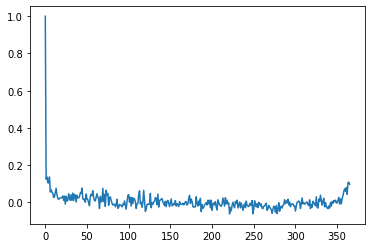

In [83]:
plt.plot(acf_df.iloc[:,1])

In [90]:
sample_df[sample_df.cluster==1]

,0,1,2,3,4,5,6,7,8,9,...,357,358,359,360,361,362,363,364,365,cluster
id,,,,,,,,,,,,,,,,,,,,,
HOBBIES_1_087_TX_3_validation,1.0,0.525025,0.532260,0.502030,0.483837,0.537519,0.537684,0.538544,0.499594,0.491771,...,0.036320,0.006201,0.008860,-0.012239,-0.009899,0.014174,0.003726,0.019773,0.009362,1
HOUSEHOLD_1_262_TX_3_validation,1.0,0.576187,0.518734,0.491327,0.467011,0.462726,0.491156,0.494358,0.479830,0.495245,...,0.172891,0.174826,0.187319,0.166450,0.152201,0.161887,0.174309,0.155262,0.144595,1
HOUSEHOLD_1_208_WI_2_validation,1.0,0.609458,0.486186,0.479486,0.435592,0.407133,0.426189,0.437714,0.438958,0.418868,...,0.037865,0.042267,0.052520,0.047248,0.046842,0.047150,0.059003,0.066811,0.063017,1
HOUSEHOLD_1_110_CA_3_validation,1.0,0.842626,0.764837,0.724310,0.711434,0.718852,0.731911,0.731101,0.705769,0.683549,...,0.241671,0.238765,0.226331,0.209651,0.204485,0.209984,0.230957,0.238397,0.226161,1
HOUSEHOLD_2_213_TX_1_validation,1.0,0.686009,0.617312,0.600682,0.576840,0.571083,0.590066,0.612577,0.559969,0.559998,...,0.240623,0.227586,0.213680,0.194464,0.188239,0.189165,0.193994,0.222881,0.211938,1
FOODS_3_403_CA_3_validation,1.0,0.744134,0.661684,0.592747,0.571012,0.556917,0.555382,0.565179,0.538252,0.506161,...,0.198546,0.185820,0.173098,0.162864,0.189612,0.206686,0.222466,0.228106,0.218376,1
HOUSEHOLD_1_127_CA_3_validation,1.0,0.429758,0.334042,0.352411,0.423522,0.488254,0.413130,0.449754,0.384385,0.433867,...,0.156433,0.159754,0.161439,0.164476,0.161652,0.167695,0.171634,0.177645,0.147398,1
HOBBIES_2_024_CA_3_validation,1.0,0.535216,0.541686,0.516150,0.517448,0.484850,0.506624,0.520155,0.483081,0.488138,...,0.129437,0.119669,0.133678,0.127205,0.133443,0.116119,0.114585,0.117049,0.126582,1
FOODS_3_278_CA_3_validation,1.0,0.441697,0.426591,0.379533,0.409137,0.418936,0.462708,0.420818,0.429387,0.421690,...,0.088120,0.078363,0.115596,0.095212,0.081986,0.061711,0.085387,0.082209,0.074692,1


In [205]:
list(cluster.T.iloc[:,j].sort_values().index[-12:-2])

[13, 44, 361, 365, 4, 363, 3, 364, 1, 2]

In [273]:
top = []
cluster = clustered_df[clustered_df.cluster==4]
for j in range(cluster.T.shape[1]):
    top_10 = cluster.T.iloc[:,j].sort_values().index[-12:-2]
    top = top + list(top_10)
top = [str(i) for i in top]
matrix = vectorizer.fit_transform(top).sum(axis= 0)
count = pd.DataFrame(data={'lag':vectorizer.get_feature_names(),'count':np.array(matrix)[0].tolist()})
#count = count.sort_values(by=['count'],ascending=False)

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [274]:
count

,lag,count
0,10,935
1,100,1
2,109,1
3,11,583
4,112,1
...,...,...
93,90,2
94,91,6
95,92,1
96,93,2


In [258]:
print(count.iloc[0,:])

lag        14
count    1857
Name: 8, dtype: object


<AxesSubplot: title={'center': 'product count by cluster'}, xlabel='cluster'>

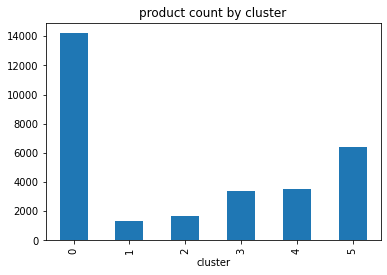

In [238]:
clustered_df.iloc[:,[0,-1]].groupby('cluster').count().plot(kind='bar',legend=None, title='product count by cluster')

In [235]:
clustered_df.iloc[:,[0,-1]]

,0,cluster
id,,
HOBBIES_1_001_CA_1_validation,1.0,3
HOBBIES_1_002_CA_1_validation,1.0,0
HOBBIES_1_003_CA_1_validation,1.0,5
HOBBIES_1_004_CA_1_validation,1.0,0
HOBBIES_1_005_CA_1_validation,1.0,0
...,...,...
FOODS_3_823_WI_3_validation,1.0,2
FOODS_3_824_WI_3_validation,1.0,5
FOODS_3_825_WI_3_validation,1.0,4


clustered_df.T.iloc[1:366,0].sort_values(ascending=False)

In [194]:
[i for i in zip(top.index[0:10],list(top[0:10]))]

[(18, 0.2673186832903682),
 (49, 0.2569305715213537),
 (13, 0.25017704662379037),
 (84, 0.2460383926156022),
 (14, 0.24115694546902017),
 (23, 0.23134646612833976),
 (16, 0.2308476665035147),
 (1, 0.23059252590357807),
 (41, 0.22821499984240076),
 (11, 0.2281198525741659)]

In [191]:
top[0:10]

18    0.267319
49    0.256931
13    0.250177
84    0.246038
14    0.241157
23    0.231346
16    0.230848
1     0.230593
41    0.228215
11    0.228120
Name: HOBBIES_1_001_CA_1_validation, dtype: float64

In [161]:
listtest = []

In [164]:
listtest = listtest + list(top)

In [165]:
listtest = str(

'[11, 41, 1, 16, 23, 14, 84, 13, 49, 18]'

In [147]:
cluster.T.iloc[:,0]

NameError: name 'cluster' is not defined